# Discovering Accounts to Follow Using Graph Mining

Lots of things can be represented as graphs. This is particularly true in this day of Big Data, online social networks, and the Internet of Things. In particular, online social networks are big business, with sites such as Facebook that have over 500 million active users (50 percent of them log in each day). These sites often monetize themselves by targeted advertising. However, for users to be engaged with a website, they often need to follow interesting people or pages.

We will look at the concept of similarity and how we can create graphs based on it. We will also see how to split this graph up into meaningful subgraphs using connected components. This simple algorithm introduces the concept of cluster analysis—splitting a dataset into subsets based on similarity.

## Creating a graph & building the network
Our task is to recommend users on online social networks based on shared connections. Our logic is that if two users have the same friends, they are highly similar and worth recommending to each other.

We are going to create a small social graph from fake Twitter users. The data we are looking for is a subset of users interested in a similar topic (again, the Python programming language) and a list of all of their friends (people they follow). With this data, we will check how similar two users are, based on how many friends they have in common.

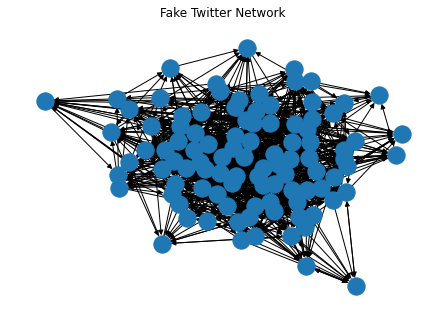

Number of nodes: 100
Number of edges: 949
Average degree: {14: 9.883928571428571, 18: 9.234126984126984, 20: 9.785714285714286, 17: 10.574660633484163, 23: 9.58695652173913, 31: 9.419354838709678, 26: 10.679487179487179, 16: 11.955357142857142, 15: 7.933333333333334, 22: 9.054545454545455, 21: 10.601731601731602, 13: 9.384615384615385, 27: 8.87037037037037, 25: 9.14, 19: 10.201754385964913, 11: 8.363636363636363, 12: 7.833333333333333, 30: 11.066666666666666, 28: 10.178571428571429}


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Create an empty directed graph
G = nx.DiGraph()

# Add nodes (Twitter users)
num_users = 100
for i in range(num_users):
    G.add_node(i)

# Add edges (connections between users)
num_connections = 1000
num_main_users = 100
for _ in range(num_connections):
    user1 = random.choice(list(G.nodes())[:num_main_users])
    user2 = random.choice([u for u in G.nodes() if u != user1])
    G.add_edge(user1, user2)

# Visualize graph
%matplotlib inline
nx.draw(G)

plt.title("Fake Twitter Network")
plt.axis('off')
plt.show()

# Print graph stats
print(f"Number of nodes: {len(G.nodes())}")
print(f"Number of edges: {len(G.edges())}")
print(f"Average degree: {nx.average_degree_connectivity(G)}")


## Creating a similarity graph

Our task is recommendation through shared friends. As mentioned previously, our logic is that, if two users have the same friends, they are highly similar. We could recommend one user to the other on this basis.

We are therefore going to take our existing graph (which has edges relating to friendship) and create a new graph. The nodes are still users, but the edges are going to be weighted edges. A weighted edge is simply an edge with a weight property. The logic is that a higher weight indicates more similarity between the two nodes
than a lower weight. This is context-dependent. If the weights represent distance, then the lower weights indicate more similarity.

For our application, the weight will be the similarity of the two users connected by that edge (based on the number of friends they share). This graph also has the property that it is not directed. This is due to our similarity computation, where the similarity of user A to user B is the same as the similarity of user B to user A.

There are many ways to compute the similarity between two lists like this. For example, we could compute the number of friends the two have in common. However, this measure is always going to be higher for people with more friends. Instead, we can normalize it by dividing by the total number of distinct friends the two have. This is called the **Jaccard Similarity**.

The Jaccard Similarity, always between 0 and 1, represents the percentage overlap of the two. Normalization is an important part of data mining exercises and generally a good thing to do (unless you have a specific reason not to). To compute this Jaccard similarity, we divide the intersection of the two sets of followers by the union of the two. These are set operations and we have lists, so we will need to convert the friends lists to sets first.

In [2]:
friends = {}
for v in G.adjacency():
    user = v[0]
    friend_list = v[1].keys()
    friends[user] = friend_list

In [3]:
len(friends)

100

In [4]:
def compute_similarity(friends1, friends2):
    if len(friends1 | friends2) == 0:
        return 0
    return len(friends1 & friends2) / len(friends1 | friends2)

def create_graph(friends, threshold=0):
    weights = []
    G = nx.Graph()
    for user1 in friends.keys():
        for user2 in friends.keys():
            if user1 == user2:
                continue
            weight = compute_similarity(friends[user1], friends[user2])
            if weight >= threshold:
                weights.append(weight)
                G.add_node(user1)
                G.add_node(user2)
                G.add_edge(user1, user2, weight=weight)
    return G, weights

G, weights = create_graph(friends)

Number of nodes: 100
Number of edges: 4950
Average degree: {99: 99.0}


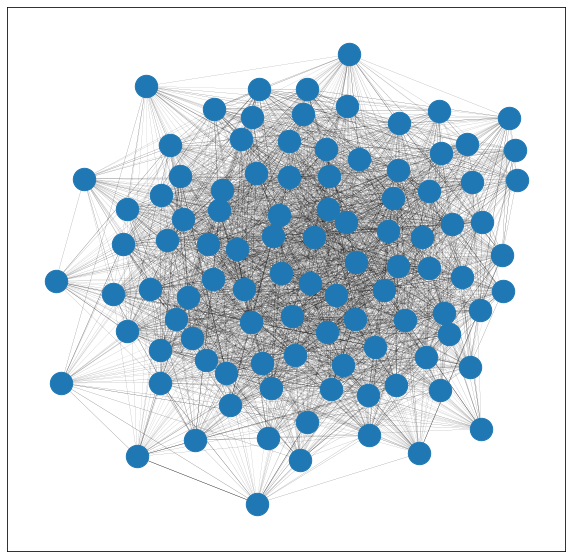

In [5]:

%matplotlib inline
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)

edgewidth = [d['weight'] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edgewidth)

# Print graph stats
print(f"Number of nodes: {len(G.nodes())}")
print(f"Number of edges: {len(G.edges())}")
print(f"Average degree: {nx.average_degree_connectivity(G)}")

The difference in this graph compared to the previous graph is that the edges determine the similarity between the nodes based on our similarity metric and not on whether one is a friend of another (although there are similarities between the two!). We can now start extracting information from this graph in order to make our recommendations.

## Finding subgraphs
From our similarity function, we could simply rank the results for each user, returning the most similar user as a recommendation—as we did with our product recommendations. Instead, we might want to find clusters of users that are all similar to each other. We could advise these users to start a group, create advertising targeting this segment, or even just use those clusters to do the
recommendations themselves.

Finding these clusters of similar users is a task called **cluster analysis**. It is a difficult task, with complications that classification tasks do not typically have. For example, evaluating classification results is relatively easy—we compare our results to the ground truth (from our training set) and see what percentage we got right. With cluster analysis, though, there isn't typically a ground truth. Evaluation usually comes down to seeing if the clusters make sense, based on some preconceived notion
we have of what the cluster should look like. Another complication with cluster analysis is that the model can't be trained against the expected result to learn—it has to use some approximation based on a mathematical model of a cluster, not what the user is hoping to achieve from the analysis.

## Connected components
One of the simplest methods for clustering is to find the **connected components** in a graph. A connected component is a set of nodes in a graph that are connected via edges. Not all nodes need to be connected to each other to be a connected component. However, for two nodes to be in the same connected component, there needs to be a way to travel from one node to another in that connected component.

`NetworkX` has a function for computing connected components that we can call on our graph. First, we create a new graph using our `create_graph` function, but this time we pass a threshold of 0.1 to get only those edges that have a weight of at least 0.1.

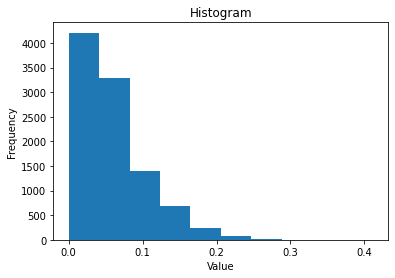

In [6]:
import numpy as np

hist, bin_edges = np.histogram(weights, bins=10)

# Plot the histogram
plt.hist(weights, bins=bin_edges)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [7]:
G, weights = create_graph(friends, .2)
sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
len(sub_graphs)

11

In [8]:
for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes())
    print(f"Subgraph {i} has {n_nodes} nodes")

Subgraph 0 has 16 nodes
Subgraph 1 has 13 nodes
Subgraph 2 has 2 nodes
Subgraph 3 has 10 nodes
Subgraph 4 has 5 nodes
Subgraph 5 has 3 nodes
Subgraph 6 has 17 nodes
Subgraph 7 has 4 nodes
Subgraph 8 has 2 nodes
Subgraph 9 has 3 nodes
Subgraph 10 has 4 nodes


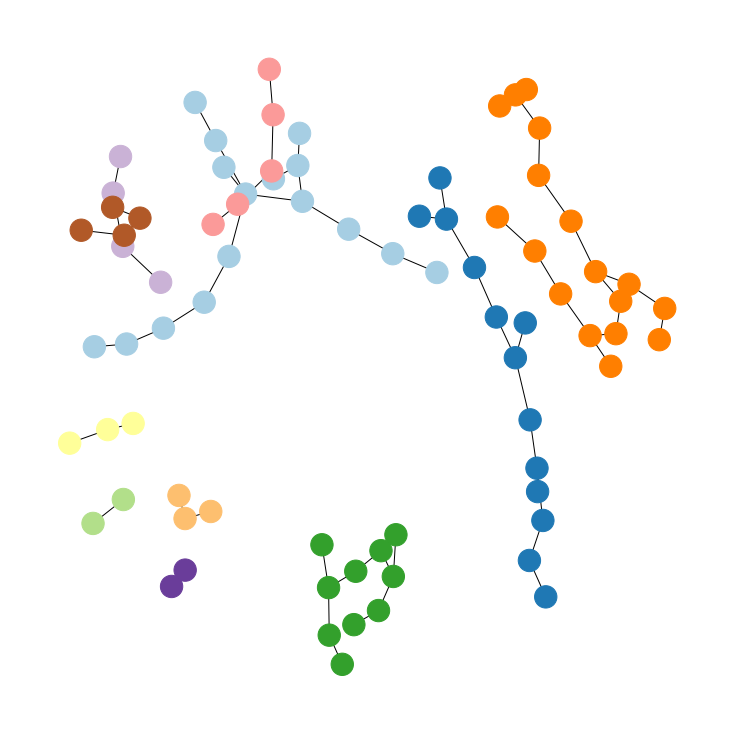

In [9]:
sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
label_dict = {}
for i, sub_graph in enumerate(sub_graphs):
    for node in sub_graph.nodes():
        label_dict[node] = i
labels = [label_dict[node] for node in G.nodes()]

plt.figure(figsize=(10,10))
nx.draw(G,node_color=labels,cmap=plt.cm.Paired, node_size=500)


In [10]:
G, weights = create_graph(friends, 0.19)
sub_graphs = [G.subgraph(c) for c in nx.connected_components(G)]
for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes())
    print(f"Subgraph {i} has {n_nodes} nodes")

Subgraph 0 has 33 nodes
Subgraph 1 has 28 nodes
Subgraph 2 has 2 nodes
Subgraph 3 has 5 nodes
Subgraph 4 has 3 nodes
Subgraph 5 has 4 nodes
Subgraph 6 has 5 nodes
Subgraph 7 has 4 nodes


8


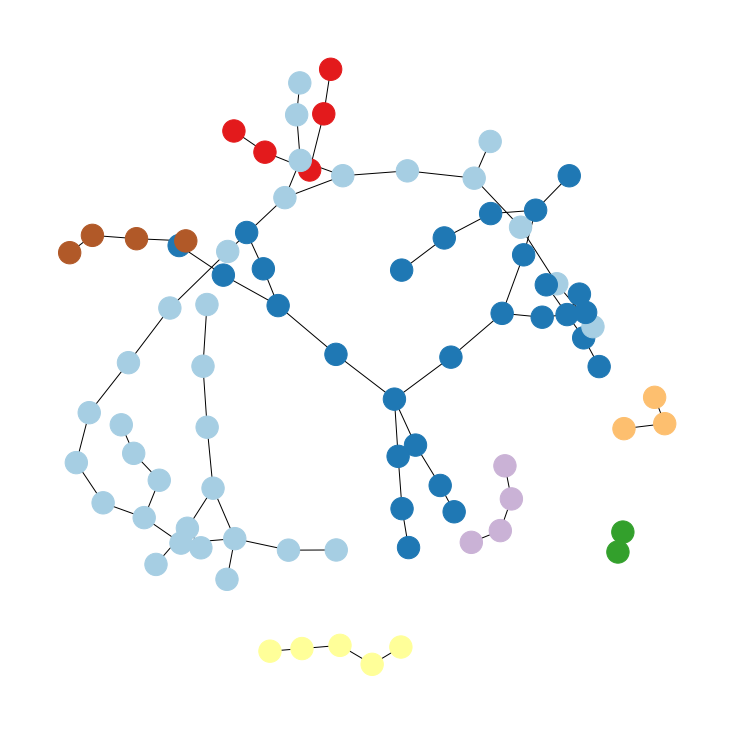

In [11]:
sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print(len(sub_graphs))
label_dict = {}
for i, sub_graph in enumerate(sub_graphs):
    for node in sub_graph.nodes():
        label_dict[node] = i
labels = [label_dict[node] for node in G.nodes()]

plt.figure(figsize=(10,10))
nx.draw(G,node_color=labels,cmap=plt.cm.Paired, node_size=500)


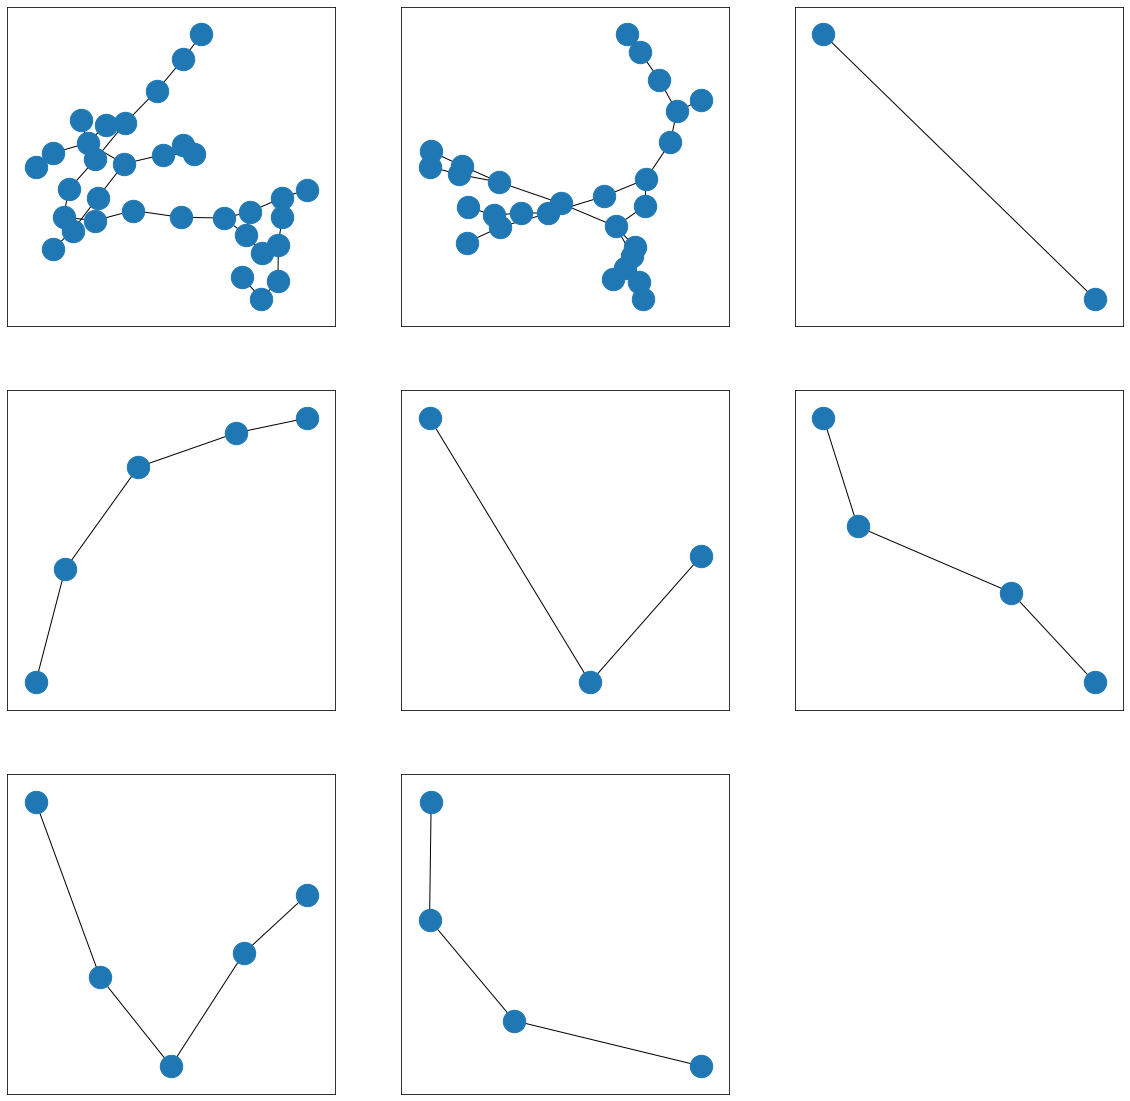

In [12]:
n_subgraphs = len(sub_graphs)
num_subplots = int(n_subgraphs/3)+1
fig = plt.figure(figsize=(20, 20))
for i, sub_graph in enumerate(sub_graphs):
    if i < n_subgraphs:
        ax = fig.add_subplot(num_subplots, 3, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, sub_graph.nodes(), ax=ax, node_size=500)
        nx.draw_networkx_edges(G, pos, sub_graph.edges(), ax=ax)

## Optimizing criteria

Our algorithm for finding these connected components relies on the threshold parameter, which dictates whether edges are added to the graph or not. In turn, this directly dictates how many connected components we discover and how big they are. From here, we probably want to settle on some notion of which is the best threshold to use. This is a very subjective problem, and there is no definitive answer. This is a major problem with any cluster analysis task.

We can, however, determine what we think a good solution should look like and define a metric based on that idea. As a general rule, we usually want a solution where:

- Samples in the same cluster (connected components) are highly similar to each other
- Samples in different clusters are highly dissimilar to each other

The **Silhouette Coefficient** is a metric that quantifies these points. Given a single sample, we define the Silhouette Coefficient as follows:

$$
s = \frac{b-a}{max(a,b)}
$$

Where $a$ is the **intra-cluster distance** or the average distance to the other samples in the sample's cluster, and $b$ is the inter-cluster distance or the average distance to the other samples in the next-nearest cluster.

To compute the overall Silhouette Coefficient, we take the mean of the Silhouettes for each sample. A clustering that provides a Silhouette Coefficient close to the maximum of 1 has clusters that have samples all similar to each other, and these clusters are very spread apart. Values near 0 indicate that the clusters all overlap and there is little distinction between clusters. Values close to the minimum of -1 indicate that samples are probably in the wrong cluster, that is, they would be better off in other clusters.

Using this metric, we want to find a solution (that is, a value for the threshold) that maximizes the *Silhouette* Coefficient by altering the threshold parameter. To do that, we create a function that takes the threshold as a parameter and computes the Silhouette Coefficient.

We then pass this into the `optimize` module of SciPy, which contains the minimize function that is used to find the minimum value of a function by altering one of the parameters. While we are interested in maximizing the Silhouette Coefficient, SciPy doesn't have a maximize function. Instead, we minimize the inverse of the Silhouette (which is basically the same thing).

The scikit-learn library has a function for computing the Silhouette Coefficient, `sklearn.metrics.silhouette_score`; however, it doesn't fix the function format that is required by the SciPy `minimize` function. The minimize function requires the variable parameter to be first (in our case, the threshold value), and any arguments to be after it. In our case, we need to pass the *friends* dictionary as an argument in order to compute the graph. The code is as follows:

In [13]:
import networkx as nx
import numpy as np
from sklearn.metrics import silhouette_score

def compute_silhouette(threshold, friends):
    try:
        G, _ = create_graph(friends, threshold=threshold)
        
        if len(G.nodes()) == 0:
            return -99  # Invalid graph
        
        sub_graphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        n_subgraphs = len(sub_graphs)

        if not (2 <= n_subgraphs < len(G.nodes()) - 1):
            return -99  # Invalid number of components, Silhouette not defined
        
        label_dict = {}
        for i, sub_graph in enumerate(sub_graphs):
            for node in sub_graph.nodes():
                label_dict[node] = i
        
        labels = np.array([label_dict[node] for node in G.nodes()])
        
        X = nx.to_numpy_array(G)
        X = 1 - X
        np.fill_diagonal(X, 0)
        
        return silhouette_score(X, labels, metric='precomputed')
    except Exception as e:
        print(f"An error occurred: {e}")
        return -99  # Return an invalid value if there's any error

# Example usage
print(compute_silhouette(0.19, friends))


0.04232147550699584


In [14]:
from scipy.optimize import minimize #(fun, x0, args=(),

def invert(func):
    def inverted_function(*args, **kwds):
        return -func(*args, **kwds)
    return inverted_function

result = minimize(invert(compute_silhouette), 0.1, method='nelder-mead', args=(friends,), options={'maxiter':10, })
print(result)

 final_simplex: (array([[0.1       ],
       [0.10007813]]), array([99., 99.]))
           fun: 99.0
       message: 'Optimization terminated successfully.'
          nfev: 20
           nit: 7
        status: 0
       success: True
             x: array([0.1])


In [18]:
G, weights = create_graph(friends, threshold=0.19)
sub_graphs = [G.subgraph(c) for c in nx.connected_components(G)]

for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes())
    print(f"Subgraph {i} has {n_nodes} nodes")


Subgraph 0 has 33 nodes
Subgraph 1 has 28 nodes
Subgraph 2 has 2 nodes
Subgraph 3 has 5 nodes
Subgraph 4 has 3 nodes
Subgraph 5 has 4 nodes
Subgraph 6 has 5 nodes
Subgraph 7 has 4 nodes


In [21]:
def silhouette_score(X, labels, metric='precomputed'):
    labels = np.array(labels)
    print(labels.shape)
    return np.mean(silhouette_samples(X, labels, metric=metric))

def silhouette_samples(X, labels, metric='precomputed'):
    print(X.shape)
    distances = X  #pairwise_distances(X, metric=metric, **kwds)
    n = labels.shape[0]
    A = np.array([_intra_cluster_distance(distances[i], labels, i) for i in range(n)])
    B = np.array([_nearest_cluster_distance(distances[i], labels, i) for i in range(n)])
    sil_samples = (B - A) / np.maximum(A, B)
    # nan values are for clusters of size 1, and should be 0
    return np.nan_to_num(sil_samples)

def _intra_cluster_distance(distances_row, labels, i):
    """Calculate the mean intra-cluster distance for sample i.

    Parameters
    ----------
    distances_row : array, shape = [n_samples]
        Pairwise distance matrix between sample i and each sample.

    labels : array, shape = [n_samples]
        label values for each sample

    i : int
        Sample index being calculated. It is excluded from calculation and
        used to determine the current label

    Returns
    -------
    a : float
        Mean intra-cluster distance for sample i
    """
    mask = (labels == labels[i])
    mask[i] = False
    mask = mask.reshape(distances_row.shape)
    # print("Cluster {}".format(i))
    # print(mask)
    # print(distances_row.flatten())
    # print(distances_row.flatten()[mask])
    a = np.mean(distances_row[mask])
    return a


def _nearest_cluster_distance(distances_row, labels, i):
    """Calculate the mean nearest-cluster distance for sample i.

    Parameters
    ----------
    distances_row : array, shape = [n_samples]
        Pairwise distance matrix between sample i and each sample.

    labels : array, shape = [n_samples]
        label values for each sample

    i : int
        Sample index being calculated. It is used to determine the current
        label.

    Returns
    -------
    b : float
        Mean nearest-cluster distance for sample i
    """
    label = labels[i]
    b = np.min([np.mean(distances_row[(labels == cur_label).reshape(distances_row.shape)])
               for cur_label in set(labels) if not cur_label == label])
    return b

In [22]:
X = nx.to_numpy_array(G)
X = 1 - X
np.fill_diagonal(X, 0)
silhouette_score(X, labels, metric='precomputed')

(84,)
(84, 84)


0.042321475506995845